In [2]:
import numpy as np
import matplotlib.pyplot as plt
from GaussianOptics import ThinLens,Gaussian_propagation2d,DrawBeamCountour
c=299792458*1000

In [3]:
#  Information about the CHAMP optics designed for CHAI receiver
#  Here the simulated design is the scale optics operating @ 158.33GHz
'''CHAMP informations'''
freq=158.333*10**9
Lambda1=c/freq
win2=2.74925
#win2=2.2
din2=26.0865
f2=70.2857
P2=ThinLens(win2, din2, f2, Lambda1)

din1=74.501
f1=74.0689
P1=ThinLens(P2['wout'], din1, f1, Lambda1)
Ls=din1+P2['dout']
Ls=30.463

In [2]:
# 1. 

In [3]:
def p_w(dz,s):
    p2=ThinLens(win2, din2+dz, f2, Lambda1)
    p1=ThinLens(p2['wout'], Ls-p2['dout'], f1, Lambda1)
    z_c, w_z, Rin, q1, phi1, beam = Gaussian_propagation2d(p1['wout'],s-dz-p1['dout'],Lambda1)
    #print('S:',s-p1['dout'])
    power=1/w_z**2
    #print(p2['din'])
    return s-p1['dout'], p1['wout'], w_z, power

In [4]:
def scan_Rx(dz,distance=1000):
    D=np.array([])
    W_out=np.array([])
    W_s=np.array([])
    P_s=np.array([])
    for n in dz:
        d, w_out, w_s, power_s =p_w(n,distance)
        D=np.append(D,d)
        W_out=np.append(W_out,w_out)
        W_s=np.append(W_s,w_s)
        P_s=np.append(P_s,power_s)
    P_s=P_s/P_s.max()
    return D, W_out, W_s, P_s

In [5]:
z=np.linspace(-3,5,2001)
D1,W1,Ws1,Power1=scan_Rx(z)
D1_4,W1_4,Ws1_4,Power1_4=scan_Rx(z,distance=1400)
D2,W2,Ws2,Power2=scan_Rx(z,distance=2000)

[2.352]
[1.732]
[0.828]


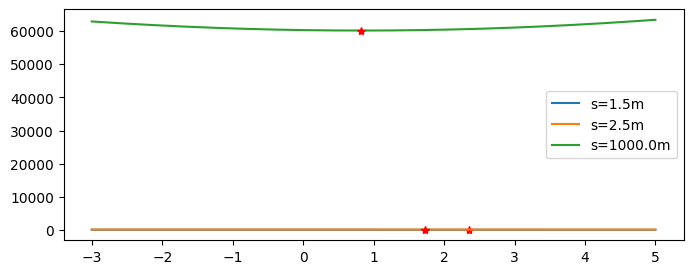

In [6]:
D_source=[1500,2500,1000000]
fig=plt.figure(figsize=(8,3))
for item in D_source:
    D,W,Ws,Ps=scan_Rx(z,distance=item)
    plt.plot(z,Ws,label='s='+str(item/1000)+'m')
    NN=np.where(Ws==Ws.min())
    print(z[NN])
    plt.plot(z[NN],Ws.min(),'r*')

plt.legend()
plt.show()

Detector distance 1.5m [2.352] [2.352]
Detector distance 2.5m [1.732] [-0.62]
Detector distance 1000.0m [0.828] [1.448]


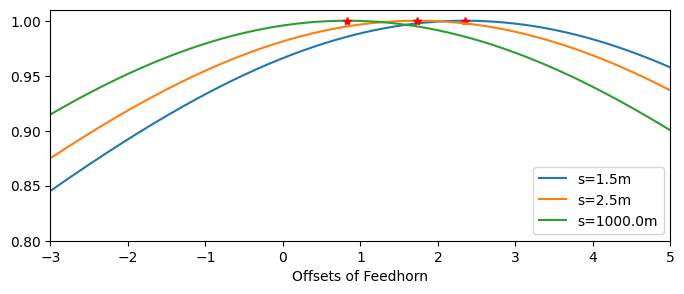

In [7]:
fig=plt.figure(figsize=(8,3))
'''Beam power in detector'''
dZ=0
for item in D_source:
    D,W,Ws,Ps=scan_Rx(z,distance=item)
    '''Beam power in detector'''
    plt.plot(z,Ps,label='s='+str(item/1000)+'m')
    NN=np.where(Ps==1.0)
    dZ=z[NN]-dZ
    print('Detector distance '+str(item/1000)+'m',z[NN],dZ)
    plt.plot(z[NN],1.0,'r*')
plt.ylim([0.8,1.01])
plt.xlim([z.min(),z.max()])
plt.legend()
plt.xlabel('Offsets of Feedhorn')
plt.show()

In [26]:
M2=ThinLens(win2, din2, P2['Rin'], Lambda1)
t=DrawBeamCountour(M2,Nin=301,Nout=301,size=1,offset=0)

In [27]:
M2['dout']

-7.131064439672602e-15

In [28]:
M2['Rout']

1e+100

In [29]:
t[0]

array([ 0.      ,  0.086955,  0.17391 ,  0.260865,  0.34782 ,  0.434775,
        0.52173 ,  0.608685,  0.69564 ,  0.782595,  0.86955 ,  0.956505,
        1.04346 ,  1.130415,  1.21737 ,  1.304325,  1.39128 ,  1.478235,
        1.56519 ,  1.652145,  1.7391  ,  1.826055,  1.91301 ,  1.999965,
        2.08692 ,  2.173875,  2.26083 ,  2.347785,  2.43474 ,  2.521695,
        2.60865 ,  2.695605,  2.78256 ,  2.869515,  2.95647 ,  3.043425,
        3.13038 ,  3.217335,  3.30429 ,  3.391245,  3.4782  ,  3.565155,
        3.65211 ,  3.739065,  3.82602 ,  3.912975,  3.99993 ,  4.086885,
        4.17384 ,  4.260795,  4.34775 ,  4.434705,  4.52166 ,  4.608615,
        4.69557 ,  4.782525,  4.86948 ,  4.956435,  5.04339 ,  5.130345,
        5.2173  ,  5.304255,  5.39121 ,  5.478165,  5.56512 ,  5.652075,
        5.73903 ,  5.825985,  5.91294 ,  5.999895,  6.08685 ,  6.173805,
        6.26076 ,  6.347715,  6.43467 ,  6.521625,  6.60858 ,  6.695535,
        6.78249 ,  6.869445,  6.9564  ,  7.043355, 

In [30]:
P2['din']+np.abs(M2['dout'])

26.086500000000008